In [25]:
import neurokit2 as nk
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import json
import os

In [26]:
def pair_peaks(peaks1, peaks2, max_distance=200):
    pairs1 = []
    pairs2 = []
    j = 0
    for i in range(len(peaks1)):
        while j < len(peaks2) and peaks2[j] < peaks1[i]:
            j += 1
        if j < len(peaks2) and abs(peaks2[j] - peaks1[i]) <= max_distance:
            pairs1.append(peaks1[i])
            pairs2.append(peaks2[j])
            j += 1
    return np.array(pairs1), np.array(pairs2)

def is_sinus_rhythm(p_peaks, r_peaks, fs, rr_threshold=0.2):
    if len(p_peaks) < 3 or len(r_peaks) < 3:
        return False

    rr_intervals = np.diff(r_peaks) / fs
    if np.std(rr_intervals) > rr_threshold:
        return False

    matched = 0
    for r in r_peaks:
        preceding_p = p_peaks[p_peaks < r]
        if len(preceding_p) > 0 and r - preceding_p[-1] < fs * 0.2:
            matched += 1

    return matched / len(r_peaks) > 0.8

def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def detect_r_peaks(signal, fs):
    # Try NeuroKit2 first
    try:
        signals, _ = nk.ecg_process(signal, sampling_rate=fs)
        r_peaks = signals.index[signals["ECG_R_Peaks"] == 1].to_numpy()
        if len(r_peaks) > 5:  # reasonable number of peaks detected
            return r_peaks
    except:
        pass
    
    # Fallback: manual peak detection with tuned parameters
    peaks, properties = find_peaks(signal, distance=int(fs*0.4), prominence=0.5)
    if len(peaks) > 0:
        return peaks
    else:
        return np.array([])


In [27]:
def check_signal_quality(ecg_signal, fs, min_r_peaks=3, min_std=0.05):
    try:
        ecg_signal = bandpass_filter(ecg_signal, fs)
        signals, _ = nk.ecg_process(ecg_signal, sampling_rate=fs)
        r_peaks = signals.index[signals["ECG_R_Peaks"] == 1].to_numpy()
        num_r_peaks = len(r_peaks)
        signal_std = np.std(ecg_signal)
        return num_r_peaks >= min_r_peaks and signal_std >= min_std
    except Exception as e:
        print(f"Signal quality check failed: {e}")
        return False

In [28]:
def extract_features(ecg_signal, fs, subject_type="fetal"):
    summary = {
        "Heart_Rate_Mean": np.nan,
        "PR_Interval_ms": np.nan,
        "QRS_Duration_ms": np.nan,
        "QT_Interval_ms": np.nan,
        "Sinus_Rhythm": False,
        "Quality_OK": False,
    }

    try:
        # Step 1: Filter the signal
        filtered_signal = bandpass_filter(ecg_signal, fs)

        # Step 2: Check signal quality
        quality_ok = check_signal_quality(filtered_signal, fs)
        summary["Quality_OK"] = quality_ok

        if not quality_ok:
            return summary  # Skip processing if poor quality

        # Step 3: Detect R-peaks (try robust method)
        r_peaks = detect_r_peaks(filtered_signal, fs)
        if len(r_peaks) < 3:
            return summary  # Not enough peaks to continue

        # Step 4: Calculate mean heart rate from detected peaks
        rr_intervals = np.diff(r_peaks) / fs
        summary["Heart_Rate_Mean"] = float(60 / np.mean(rr_intervals))

        # Step 5: Process with NeuroKit2 for full feature extraction (optional)
        signals, info = nk.ecg_process(filtered_signal, sampling_rate=fs)
        features = nk.ecg_analyze(signals, sampling_rate=fs)

        # Extract other peaks for interval calculation
        q = signals.index[signals["ECG_Q_Peaks"] == 1].to_numpy()
        s = signals.index[signals["ECG_S_Peaks"] == 1].to_numpy()
        p = signals.index[signals["ECG_P_Peaks"] == 1].to_numpy()
        t = signals.index[signals["ECG_T_Offsets"] == 1].to_numpy()

        # Calculate intervals with paired peaks
        if len(q) > 0 and len(s) > 0:
            q_matched, s_matched = pair_peaks(q, s)
            if len(q_matched) > 0:
                qrs = ((s_matched - q_matched) / fs * 1000)
                summary["QRS_Duration_ms"] = float(np.mean(qrs))

        if len(p) > 0 and len(q) > 0:
            p_matched, q_matched = pair_peaks(p, q)
            if len(p_matched) > 0:
                pr = ((q_matched - p_matched) / fs * 1000)
                summary["PR_Interval_ms"] = float(np.mean(pr))

        if len(q) > 0 and len(t) > 0:
            q_matched, t_matched = pair_peaks(q, t)
            if len(q_matched) > 0:
                qt = ((t_matched - q_matched) / fs * 1000)
                summary["QT_Interval_ms"] = float(np.mean(qt))

        # Step 6: Sinus rhythm check with detected p and r peaks
        summary["Sinus_Rhythm"] = is_sinus_rhythm(p, r_peaks, fs)

    except Exception as e:
        print(f"Feature extraction failed: {e}")

    return summary

In [29]:
def sanitize_for_json(data):
    """Convert NumPy types to native Python types recursively for JSON serialization."""
    if isinstance(data, dict):
        return {k: sanitize_for_json(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [sanitize_for_json(item) for item in data]
    elif isinstance(data, np.generic):
        return data.item()
    else:
        return data

In [30]:
base_dir = "ica_cleaned_signals2"  
output_dir = "metrics_2"
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(base_dir) if f.endswith(".npy")]

fs = 250  # sampling frequency (adjust if needed)

for filename in files:
    filepath = os.path.join(base_dir, filename)

    # All files are fetal ECG cleaned signals now
    subject_type = "fetal"

    signal = np.load(filepath)

    try:
        features = extract_features(signal, fs, subject_type)

        # Add metadata
        features["subject_type"] = subject_type
        features["filename"] = filename

        # Convert all values to JSON-safe types
        json_safe_features = sanitize_for_json(features)

        # Save to JSON
        json_filename = filename.replace(".npy", "_features.json")
        json_path = os.path.join(output_dir, json_filename)

        with open(json_path, "w") as json_file:
            json.dump(json_safe_features, json_file, indent=4)

        print(f"Saved features for {filename} to {json_filename}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

Saved features for a72_cleaned.npy to a72_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a30_cleaned.npy to a30_cleaned_features.json
Saved features for a40_cleaned.npy to a40_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a25_cleaned.npy to a25_cleaned_features.json
Saved features for a55_cleaned.npy to a55_cleaned_features.json
Saved features for a67_cleaned.npy to a67_cleaned_features.json
Saved features for a17_cleaned.npy to a17_cleaned_features.json
Saved features for a49_cleaned.npy to a49_cleaned_features.json
Saved features for a39_cleaned.npy to a39_cleaned_features.json
Signal quality check failed: index 11 is out of bounds for axis 0 with size 9
Saved features for a50_cleaned.npy to a50_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a20_cleaned.npy to a20_cleaned_features.json
Saved features for a12_cleaned.npy to a12_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a62_cleaned.npy to a62_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a29_cleaned.npy to a29_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a59_cleaned.npy to a59_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a45_cleaned.npy to a45_cleaned_features.json
Saved features for a35_cleaned.npy to a35_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a68_cleaned.npy to a68_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a46_cleaned.npy to a46_cleaned_features.json
Saved features for a36_cleaned.npy to a36_cleaned_features.json
Saved features for a04_cleaned.npy to a04_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a74_cleaned.npy to a74_cleaned_features.json
Saved features for a61_cleaned.npy to a61_cleaned_features.json
Saved features for a53_cleaned.npy to a53_cleaned_features.json
Saved features for a23_cleaned.npy to a23_cleaned_features.json
Signal quality check failed: integer division or modulo by zero
Saved features for a64_cleaned.npy to a64_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Saved features for a14_cleaned.npy to a14_cleaned_features.json
Saved features for a08_cleaned.npy to a08_cleaned_features.json
Saved features for a26_cleaned.npy to a26_cleaned_features.json
Signal quality check failed: index 9 is out of bounds for axis 0 with size 9
Saved features for a56_cleaned.npy to a56_cleaned_features.json
Saved features for a33_cleaned.npy to a33_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a43_cleaned.npy to a43_cleaned_features.json
Saved features for a71_cleaned.npy to a71_cleaned_features.json
Saved features for a34_cleaned.npy to a34_cleaned_features.json
Saved features for a44_cleaned.npy to a44_cleaned_features.json
Saved features for a06_cleaned.npy to a06_cleaned_features.json
Saved features for a58_cleaned.npy to a58_cleaned_features.json
Saved features for a28_cleaned.npy to a28_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a63_cleaned.npy to a63_cleaned_features.json
Saved features for a13_cleaned.npy to a13_cleaned_features.json
Saved features for a21_cleaned.npy to a21_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a51_cleaned.npy to a51_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a66_cleaned.npy to a66_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a38_cleaned.npy to a38_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a48_cleaned.npy to a48_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a54_cleaned.npy to a54_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a24_cleaned.npy to a24_cleaned_features.json
Saved features for a41_cleaned.npy to a41_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a31_cleaned.npy to a31_cleaned_features.json
Saved features for a03_cleaned.npy to a03_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a73_cleaned.npy to a73_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a70_cleaned.npy to a70_cleaned_features.json
Saved features for a42_cleaned.npy to a42_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a32_cleaned.npy to a32_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Saved features for a57_cleaned.npy to a57_cleaned_features.json
Signal quality check failed: cannot convert float NaN to integer
Saved features for a27_cleaned.npy to a27_cleaned_features.json
Saved features for a15_cleaned.npy to a15_cleaned_features.json
Saved features for a65_cleaned.npy to a65_cleaned_features.json
Saved features for a22_cleaned.npy to a22_cleaned_features.json
Saved features for a52_cleaned.npy to a52_cleaned_features.json
Signal quality check failed: integer division or modulo by zero
Saved features for a60_cleaned.npy to a60_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Saved features for a10_cleaned.npy to a10_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a75_cleaned.npy to a75_cleaned_features.json
Saved features for a05_cleaned.npy to a05_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Saved features for a19_cleaned.npy to a19_cleaned_features.json
Saved features for a69_cleaned.npy to a69_cleaned_features.json
Saved features for a37_cleaned.npy to a37_cleaned_features.json
Saved features for a47_cleaned.npy to a47_cleaned_features.json


/opt/anaconda3/envs/icsts/lib/python3.13/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Detected R-peaks: 197


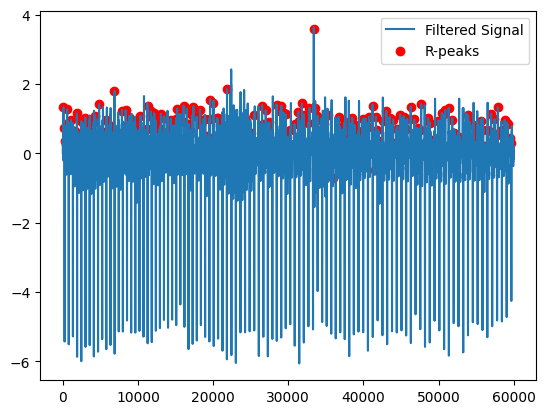

Manual HR from detected peaks: 49.35 bpm


In [31]:
# Load your cleaned signal
signal = np.load('ica_cleaned_signals2/a03_cleaned.npy')

# Try a looser filter
filtered_signal = bandpass_filter(signal, fs, lowcut=0.5, highcut=30)

# Process with NeuroKit2 and plot R-peaks
signals, info = nk.ecg_process(filtered_signal, sampling_rate=fs)
r_peaks = signals.index[signals["ECG_R_Peaks"] == 1].to_numpy()
print(f"Detected R-peaks: {len(r_peaks)}")

import matplotlib.pyplot as plt
plt.plot(filtered_signal, label='Filtered Signal')
plt.scatter(r_peaks, filtered_signal[r_peaks], color='red', label='R-peaks')
plt.legend()
plt.show()

# Compute heart rate manually for comparison
rr_intervals = np.diff(r_peaks) / fs
manual_hr = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan
print(f"Manual HR from detected peaks: {manual_hr:.2f} bpm")
